Typical ML problems:

**Customer Retention**

Demo based on Kaggle dataset aimed at Training and Testing Machine Learning models:
* hyperparameters tuning and evaluation
* feature Selection
* model serialisation

dataset:
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents


In [1]:
#libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pylab

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.metrics import mean_squared_error,mean_absolute_error
%matplotlib inline

import time
from scipy.stats import pearsonr

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
import pandas as pd
import io
ch = pd.read_csv(io.BytesIO(uploaded['WA_Fn-UseC_-Telco-Customer-Churn.csv']))
ch.info()
ch.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
ch.Churn.describe()

count     7043
unique       2
top         No
freq      5174
Name: Churn, dtype: object

Overall Customer Churn percentage in the given dataset is 26.54 %


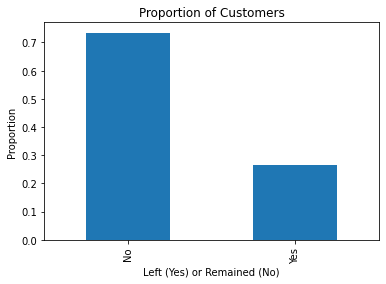

In [5]:
_ = (ch.groupby('Churn')['customerID'].count()/ch['customerID'].count()).plot.bar()
_ = plt.title('Proportion of Customers')
_ = plt.ylabel('Proportion')
_ = plt.xlabel('Left (Yes) or Remained (No)')
print('Overall Customer Churn percentage in the given dataset is {} %'.format(round(ch.Churn.replace({'No':0,'Yes':1}).mean()*100,2)))

Clear imbalance in the target attribute

In [6]:
# check unique values of each column
for column in ch.columns:
    print('Column: {} - Unique Values: {}'.format(column, ch[column].unique()))

Column: customerID - Unique Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: ['No phone service' 'No' 'Yes']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' 'No internet service']
Column: TechSuppor

In [7]:
ch['Ch10'] = ch['Churn'].replace({'Yes':1,'No':0})

In [8]:
# Change No internet service to NoInt for brevity
ch[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] = ch[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].astype(str).replace({'No internet service': 'NoInt'})
ch['MultipleLines'] = ch['MultipleLines'].replace({'No phone service':'NoPh'})

In [56]:
y = ch.Ch10
X = ch.drop(['customerID','Churn','Ch10','TotalCharges','PhoneService'],axis=1,inplace=False).copy()
temp = ch[['tenure','MonthlyCharges','SeniorCitizen']]
X.drop(['tenure','MonthlyCharges','SeniorCitizen'],axis=1,inplace=True)
#per each categorical varuiables
X = X.apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes)
X[['tenure','MonthlyCharges','SeniorCitizen']] = temp
X1 = X.copy() # Saving a copy
X1.info()
X1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   gender            7043 non-null   int8 
 1   Partner           7043 non-null   int8 
 2   Dependents        7043 non-null   int8 
 3   MultipleLines     7043 non-null   int8 
 4   InternetService   7043 non-null   int8 
 5   OnlineSecurity    7043 non-null   int8 
 6   OnlineBackup      7043 non-null   int8 
 7   DeviceProtection  7043 non-null   int8 
 8   TechSupport       7043 non-null   int8 
 9   StreamingTV       7043 non-null   int8 
 10  StreamingMovies   7043 non-null   int8 
 11  Contract          7043 non-null   int8 
 12  PaperlessBilling  7043 non-null   int8 
 13  PaymentMethod     7043 non-null   int8 
dtypes: int8(14)
memory usage: 96.4 KB


,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,1,0,1,0,0,2,0,0,0,0,0,1,2
1,1,0,0,0,0,2,0,2,0,0,0,1,0,3
2,1,0,0,0,0,2,2,0,0,0,0,0,1,3
3,1,0,0,1,0,2,0,2,2,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,2


**Modeling, tuning of models - hyperparemeters tuning for Model candidates, Feature selection**


topics:

train test split - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

random forest clasifier - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

cross  validation (CV) - https://scikit-learn.org/stable/modules/cross_validation.html

HP tuning: randomised search CV - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

HP tuning: grid search CV - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [10]:
X.shape[1]

17

In [11]:
X.head()

,gender,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,SeniorCitizen
0,0,1,0,1,0,0,2,0,0,0,0,0,1,2,1,29.85,0
1,1,0,0,0,0,2,0,2,0,0,0,1,0,3,34,56.95,0
2,1,0,0,0,0,2,2,0,0,0,0,0,1,3,2,53.85,0
3,1,0,0,1,0,2,0,2,2,0,0,1,0,0,45,42.30,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,2,2,70.70,0


In [30]:
Y = ch.Churn
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Ch10, dtype: int64

In [31]:
y.describe()

count    7043.000000
mean        0.265370
std         0.441561
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Ch10, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape[0]


4930

In [14]:
X_test.shape[0]

2113

BEST {'class_weight': {0: 1, 1: 0.55}, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} 0.7924951976274686
############# based on standard predict ################
Accuracy on training data: 78.97%
Accuracy on test data:     78.32%
confusion_matrix on test data
[[1509   30]
 [ 428  146]]
classification report on test data
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1539
           1       0.83      0.25      0.39       574

    accuracy                           0.78      2113
   macro avg       0.80      0.62      0.63      2113
weighted avg       0.79      0.78      0.74      2113

########################################################


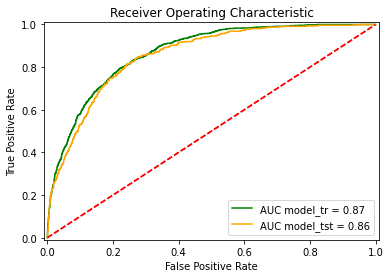

In [52]:
# parameters
# manipulation with class weight lead to different ratio between P/R
parameters = {'class_weight': [{0: 1, 1: 0.55}], #  {0: 1, 1: 0.6}],
                                        'max_depth': [  6], #complecxity of model .. more complex can have lower generalisation powere.. will overfit
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [  3,4,5],
                                        'min_samples_split': [2],
                                        'n_estimators': [100, 140, 200]} #in ensemble - how many DT
rf,aucrf1,aucrf2 = do_classify(RandomForestClassifier(verbose=0, random_state=1), parameters, X_train, y_train, X_test, y_test, score_func='precision', n_folds=5, n_jobs=-1,label=1,prob_dec=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc

**on selected subset of features:**

BEST {'class_weight': {0: 1, 1: 2}, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 71} 0.7370155888976632
############# based on standard predict ################
Accuracy on training data: 78.19%
Accuracy on test data:     76.72%
confusion_matrix on test data
[[1214  338]
 [ 154  407]]
classification report on test data
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1552
           1       0.55      0.73      0.62       561

    accuracy                           0.77      2113
   macro avg       0.72      0.75      0.73      2113
weighted avg       0.80      0.77      0.78      2113

########################################################


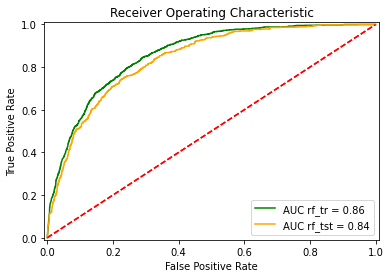

In [22]:
Xtrain, Xdev, ytrain, ydev = train_test_split(X10,y,test_size=0.3,stratify=y, random_state=42)
# This is commented because hyperparameter tuning is not done currently.
#Xdev, Xtest, ydev,ytest = train_test_split(Xt,yt,test_size=0.5,random_state=42,stratify=yt)
parameters = {'class_weight': [{0: 1, 1: 0.5}, {0: 1, 1: 2}],
                                        'max_depth': [  5],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [43, 71]}
rf,aucrf1,aucrf2 = do_classify(RandomForestClassifier(verbose=0), parameters, Xtrain,ytrain,Xdev,ydev, score_func='recall', n_folds=5, model_name='rf', n_jobs=-1,label=1,prob_dec=1)

BEST {'alpha': 0.01, 'hidden_layer_sizes': [10, 10]} 0.6516555325376278
############# based on standard predict ################
Accuracy on training data: 79.76%
Accuracy on test data:     79.79%
confusion_matrix on test data
[[1368  171]
 [ 256  318]]
classification report on test data
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1539
           1       0.65      0.55      0.60       574

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113

########################################################


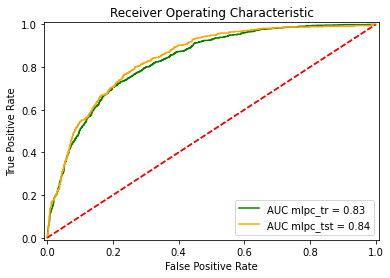

In [51]:
from sklearn.neural_network import MLPClassifier

parameters = {'hidden_layer_sizes': [[10,10], [12,6,12]],
                    'alpha': [ 0.01,0.5]
                                      }
sc = StandardScaler()  
Xs = sc.fit_transform(X10)
XtrainNN, XtNN, ytrainNN,ytNN = train_test_split(Xs,y,test_size=0.3,  random_state=42)                                
mlpc,aucrf1,aucrf2 = do_classify(MLPClassifier(solver="adam", random_state=1, max_iter=2000, early_stopping=True), parameters, XtrainNN, ytrainNN,XtNN,ytNN, score_func='precision', n_folds=5, model_name='mlpc', n_jobs=-1,label=1,prob_dec=1)

In [29]:
pd.DataFrame(Xs).describe().T

,count,mean,std,min,25%,50%,75%,max
0,7043.0,-2.371776e-16,1.000071,-1.183234,-1.183234,0.172250,0.172250,1.527734
1,7043.0,1.975481e-16,1.000071,-0.918838,-0.918838,0.244242,1.407321,1.407321
2,7043.0,3.610471e-16,1.000071,-1.029919,-1.029919,0.106315,1.242550,1.242550
3,7043.0,-2.491893e-16,1.000071,-1.027910,-1.027910,0.108600,1.245111,1.245111
4,7043.0,-6.847663e-17,1.000071,-0.925262,-0.925262,0.235518,1.396299,1.396299
5,7043.0,-1.484921e-16,1.000071,-0.828207,-0.828207,-0.828207,0.371271,1.570749
6,7043.0,-5.924868e-16,1.000071,-1.205113,-1.205113,0.829798,0.829798,0.829798
7,7043.0,7.235445e-17,1.000071,-1.474052,-0.537747,0.398558,0.398558,1.334863
8,7043.0,5.945991e-17,1.000071,-1.318165,-0.951682,-0.137274,0.921455,1.613701
9,7043.0,-8.291599e-17,1.000071,-1.545860,-0.972540,0.185733,0.833833,1.794352


**Utils**


In [15]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid of hyperparameters to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
from sklearn.model_selection import GridSearchCV

def cv_optimize(clf, parameters, X, y, n_jobs=2, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    #print(gs.grid_scores_)
    best = gs.best_estimator_
    return best
#------------------------------------------------------------------------------#
# Function to plot ROC and find area under ROC                                 #
#------------------------------------------------------------------------------#
def find_auc_score(clf,Xin,yin,color='b',name='LogReg',label=1,prob=1) :
    '''Function to plot Receiver characteristics and find AUC'''
    if prob == 1:
        yscore = clf.predict_proba(Xin)
    else :
        yscore = clf.decision_function(Xin)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yin, yscore[:,label],pos_label=label)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate,color ,label='AUC '+name+' = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return roc_auc


def pre_process_Xy(Xarray,yarray,test_tr_split_size=0.4) :
    '''Function to split given data into test and (train, dev) set'''
    Xtr,Xdev,ytr,ydev = train_test_split(Xarray,yarray,test_size=test_tr_split_size,random_state=42,stratify=yarray)
    return Xtr,Xdev,ytr,ydev
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def plot_train_test_error(clf,X,y,N=50):
    '''This function plots Train and Test Accuracy for different lengths'''

    training_error = np.empty([N,1])
    dev_error = np.empty([N,1])
    len_tr = int(X.shape[0]/N)
    re_ind = np.random.permutation(X.index)
    X = X.reindex(re_ind)
    y = y.reindex(re_ind)
    for i in range(N) :
        X1 = X[:(i+1)*len_tr]
        y1 = y[:(i+1)*len_tr]
        Xtr,Xte,ytr,yte = train_test_split(X1,y1,test_size=0.5,random_state=42,stratify=y1)
        clf = clf.fit(Xtr, ytr)
        training_error[i,0] = 1 - clf.score(Xtr, ytr)
        dev_error[i,0] = 1 - clf.score(Xte, yte)
    
    plt.plot(np.arange(N)*len_tr,training_error.reshape(np.arange(N).shape),label='train error')
    plt.plot(np.arange(N)*len_tr,dev_error.reshape(np.arange(N).shape),color='m',label='test error')
    plt.title('Train Error and Test Error Vs Number of Samples used (train: test 1:1 ratio)')
    plt.ylabel('Error rate')
    plt.xlabel('Number of samples')
    plt.legend(loc='best')
    return
    
def do_classify(clf, parameters, Xtr,ytr,Xdev,ydev, score_func=None, n_folds=5, n_jobs=2,model_name='model',label=1,prob_dec=1):

    if parameters:
        clf = cv_optimize(clf, parameters, Xtr, ytr, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtr, ytr)
    training_accuracy = clf.score(Xtr, ytr)
    test_accuracy = clf.score(Xdev, ydev)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
    print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
    print("confusion_matrix on test data")
    ypred =  clf.predict(Xdev)
    print(confusion_matrix(ydev,ypred))
    print("classification report on test data")
    print(classification_report(ydev,ypred))
    print("########################################################")
  #  multi_auc_roc(clf,Xdev,ydev,prob=1)
    auc_tr = find_auc_score(clf,Xtr,ytr,color='g',name=model_name+'_tr',label=label,prob=prob_dec) 
    auc_dev = find_auc_score(clf,Xdev,ydev,color='orange',name=model_name+'_tst',label=label,prob=prob_dec) 
    return clf,auc_tr,auc_dev

**Selection of features**

*RFE* - recursive feature eliminatio: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Chosen Predictors: Index(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges'],
      dtype='object')
Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      1552
           1       0.79      0.22      0.34       561

    accuracy                           0.78      2113
   macro avg       0.78      0.60      0.60      2113
weighted avg       0.78      0.78      0.73      2113

Dev Set Accuracy % 77.71
Train set Accuracy % 78.13


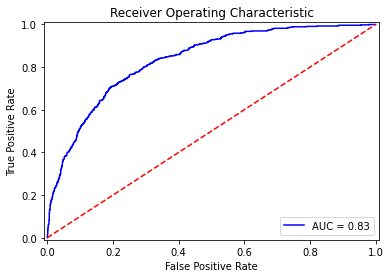

In [17]:
# Trying Feature Selection by limiting to 10
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
from sklearn.feature_selection import RFE
model = RandomForestClassifier(class_weight={0: 1, 1: 0.5}, max_depth=5)
rfe = RFE(estimator=model, n_features_to_select=10, step=1)
Xcpy = X.copy()
Xtrain, Xdev, ytrain,ydev = train_test_split(X,y,test_size=0.3,stratify=y)
rfe = rfe.fit(Xtrain, ytrain)
# After RFE has chosen, now do a prediction using that
print("Chosen Predictors:",Xcpy.columns[rfe.support_])
Xp = Xcpy.loc[:,Xcpy.columns[rfe.support_]]
Xp = sc.fit_transform(Xp)
Xtrain1, Xt, ytrain1,yt = train_test_split(Xp,y,test_size=0.3,stratify=y)
rf = RandomForestClassifier(max_depth= 5, class_weight={0: 1, 1: 0.5}, n_jobs=-1) #(C=100, class_weight={0: 1,1: 0.8})
rf.fit(Xtrain1,ytrain1)
yp = rf.predict(Xt)
print("Report:\n",classification_report(yt,yp))
print("Dev Set Accuracy %",np.round(accuracy_score(yt,yp)*100,2))
print("Train set Accuracy %",np.round(accuracy_score(ytrain1,rf.predict(Xtrain1))*100,2))
yprob = rf.predict_proba(Xt)
false_positive_rate, true_positive_rate, thresholds = roc_curve(yt, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
_ = plt.title('Receiver Operating Characteristic')
_ = plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
_ = plt.legend(loc='lower right')
_ = plt.plot([0,1],[0,1],'r--')
_ = plt.xlim([-0.01,1.01])
_ = plt.ylim([-0.01,1.01])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')

In [18]:
X10 = pd.DataFrame(Xcpy[Xcpy.columns[rfe.support_]])
X10.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges
0,0,0,2,0,0,0,1,2,1,29.85
1,0,2,0,2,0,1,0,3,34,56.95
2,0,2,2,0,0,0,1,3,2,53.85
3,0,2,0,2,2,1,0,0,45,42.30
4,1,0,0,0,0,0,1,2,2,70.70


**Serialisation of models**

In [24]:
import pickle
# create an iterator object with write permission - model.pkl
with open('model.pkl', 'wb') as file:
    pickle.dump(mlpc, file)
    

In [25]:
ls

model.pkl  sample_data/  WA_Fn-UseC_-Telco-Customer-Churn.csv


In [26]:
# load saved model
with open('model.pkl' , 'rb') as f:
    lr = pickle.load(f)

In [27]:
lr.predict([[-0.656683,-0.993300,1.416421,-0.925373,0.371074,-1.203269,0.967739,-0.431429, 0.5,0.5]]) 

array([0])

In [61]:
lr.predict([[0.656683,0.993300,1.416421,0.925373,0.371074,1.203269,0.967739,0.431429, -0.5,-0.5], [0.656683,0.993300,1.416421,0.925373,0.371074,1.203269,0.967739,0.431429, -0.5,0.5]]) 

array([0, 0])

In [72]:


best_model = RandomForestClassifier(verbose=0, random_state=1, class_weight= {0: 1, 1: 4}, max_depth = 6, max_features= 'auto', min_samples_leaf= 4, min_samples_split= 2, n_estimators = 100 )
best_model.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=6,
                       min_samples_leaf=4, random_state=1)

In [73]:
training_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)
print("############# based on standard predict ################")
print("Accuracy on training data: %0.2f" % (100*training_accuracy)+'%')
print("Accuracy on test data:     %0.2f" % (100*test_accuracy)+'%')
print("confusion_matrix on test data")
ypred =  best_model.predict(X_test)
print(confusion_matrix(y_test,ypred))
print("classification report on test data")
print(classification_report(y_test,ypred))
print("########################################################")


############# based on standard predict ################
Accuracy on training data: 73.20%
Accuracy on test data:     72.22%
confusion_matrix on test data
[[1016  523]
 [  64  510]]
classification report on test data
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1539
           1       0.49      0.89      0.63       574

    accuracy                           0.72      2113
   macro avg       0.72      0.77      0.71      2113
weighted avg       0.82      0.72      0.74      2113

########################################################


In [74]:
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)



In [75]:
with open('best_model.pkl' , 'rb') as f:
    best_m = pickle.load(f)

In [76]:
best_m.predict([[1,	0,	0,	0,	0,	2,	2,	0,	0,	0,	0,	0,	1,	3,	2,	53.85,	0], [1,	0,	0,	0,	0,	2,	2,	0,	0,	0,	0,	0,	1,	3,	49,	50.85,	0]]) 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1, 0])

**Further inspiration end-to-end notebook on the same kaggle dataset:**



https://towardsdatascience.com/end-to-end-machine-learning-project-telco-customer-churn-90744a8df97d